<a href="https://colab.research.google.com/github/ioahKwon/Machine-Learning-Deep-Learning/blob/master/%5B%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D%EA%B3%BC%EB%94%A5%EB%9F%AC%EB%8B%9D%5D_Week_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **[머신러닝과딥러닝] 수업 정리 Week #10**

### _2020.08._ SKKU Lecture Summary by IOAH


---





### 1. Colab 환경에서 MNIST 데이터 예측을 위한 MLP 모형 설계

이전 과제까지는 jupyter notebook을 이용해서 과제를 수행했지만 이번부터는 Google colab을 이용하여 실습을 진행하도록 하겠다. 우선 구글 드라이브에 데이터 파일을 업로드하고 COLAB과 드라이브를 연동해준다. 그 후 런타임 유형을 GPU로 설정해준다. 원래는 케라스 라이브러리에서 바로 MNIST 데이터를 불러올 수 있으나, 이번 실습에서는 연결된 구글 드라이브에 미리 업로드했던 MNIST 데이터를 로드한다. 이번 실습은 MLP의 전체적인 구조 및 작동 원리를 알아보기 위해 라이브러리를 사용하지 않고 클래스와 함수를 이용해 직접 정의해본다.

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
a='hello colab'
print(a)

hello colab


잘 동작하는 것을 확인할 수 있다. 그다음 60000개의 mnist train data와 10000개의 mnist test data를 불러오고 matplotlib와 numpy를 이용하여 데이터를 시각화해본다. Numpy를 통해 픽셀 정보를 일렬로 나열하고 이를 다시 28x28로 바꾼다. Gray scale 이미지는 아래와 같다.

In [ ]:
#mnist_train(60000개)과 mnist_test(10000개) 데이터를 각각 불러온다.
data_file = open("/content/gdrive/My Drive/data/mnist_train.csv", "r") #연결되어 있는 구글 드라이브에 업로드했던 데이터를 코랩 환경으로 불러오는 코드
training_data = data_file.readlines()
data_file.close()

test_data_file = open("/content/gdrive/My Drive/data/mnist_test.csv", "r")
test_data = test_data_file.readlines()
test_data_file.close()

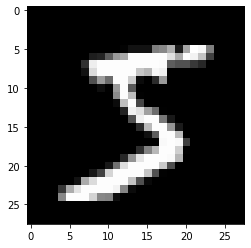

In [ ]:
#matplotlib과 numpy라이브러리를 불러온 후 데이터 하나를 시각화해본다.
import matplotlib.pyplot as plt
import numpy as np

t = np.asfarray(training_data[0].split(","))

# 일렬로 늘어진 픽셀정보를 28x28 행렬로 바꾼다
n = t[1:].reshape(28,28)

plt.imshow(n, cmap='gray')
plt.show()

우선 먼저 클래스를 선언한 후 input_layer, hidden_layer, output_layer 각각의 노드 개수를 인자로 입력받을 수 있도록 매개변수를 초기화한다. 이번 실습에서는 hidden layer를 3개 쌓아보도록 하자. 그 다음 층별 가중치 값들을 레이어의 층 수에 맞춰 랜덤으로 초기화하고 forward 방향으로 예측을 수행하게 될 predict() 함수를 정의한다. Activation function은 차례로 sigmoid, tanh, sigmoid, softmax를 쓰도록 한다. 그리고 training data로 학습을 진행하도록 모델을 설계한다. 이 함수는 입력받은 epoch 동안 지정해준 learning rate를 통해 각 층의 activation function에 맞춰 feed-forward propagation과 back propagation을 수행하고 가중치가 계속 업데이트 되도록 코드를 짠다. 

그 후 현재 neural network의 accuracy를 출력하는 함수를 정의한다. 이 함수를 통해 test 데이터에 대한 예측 정확도를 출력하면서 학습이 이루어짐에 따른 정확도 변화를 볼 수 있다. 이후 sigmoid와 normalize, tanh, softmax함수를 정의한다.

In [ ]:
class DeepNeuralNetwork:
    #DeepNeuralNetwork 클래스를 initialize
    def __init__(self, input_layers, hidden_layer_1, hidden_layer_2, hidden_layer_3, output_layers):
        self.inputs = input_layers
        self.hidden_1 = hidden_layer_1
        self.hidden_2 = hidden_layer_2
        self.hidden_3 = hidden_layer_3
        self.outputs = output_layers
        self.test_data = None

        #가중치 값들을 모두 랜덤으로 초기화
        self.w_ih = np.random.randn(self.inputs, self.hidden_1) / np.sqrt(self.inputs/2)
        self.w_hh_12 = np.random.randn(self.hidden_1, self.hidden_2) / np.sqrt(self.hidden_1/2)
        self.w_hh_23 = np.random.randn(self.hidden_2, self.hidden_3) / np.sqrt(self.hidden_2/2)
        self.w_ho = np.random.randn(self.hidden_3, self.outputs) / np.sqrt(self.hidden_3/2)

    # feed-forward를 진행한다.
    def predict(self, x):
        # 문자열을 float array로 바꾸는 과정
        data = self.normalize(np.asfarray(x.split(',')))

        # 0번은 레이블이므로 제외
        data = data[1:]

        #3개의 은닉층(2개의 sigmoid와 1개의 tanh)과 하나의 출력층(softmax)
        layer_1 = self.sigmoid(np.dot(data, self.w_ih))
        layer_2 = self.tanh(np.dot(layer_1, self.w_hh_12))
        layer_3 = self.sigmoid(np.dot(layer_2, self.w_hh_23))
        output = self.softmax(np.dot(layer_3, self.w_ho))
        return output

    # training_data로 학습 진행
    def train(self, training_data, learning_rate, epoch):
        for ech in range(0, epoch):
            for i, x in enumerate(training_data):
                target = np.array(np.zeros(self.outputs) + learning_rate, ndmin=2)
                target[0][int(x[0])] = 1-learning_rate
                x = self.normalize(np.asfarray(x.split(",")))

                # feed-forward propagation
                layer1 = self.sigmoid(np.dot(x[1:], self.w_ih))
                layer2 = self.tanh(np.dot(layer1, self.w_hh_12))
                layer3 = self.sigmoid(np.dot(layer2, self.w_hh_23))
                layer4 = self.softmax(np.dot(layer3, self.w_ho))

                # back propagation
                layer4_reverse = (target - layer4)
                layer3_reverse = layer4_reverse.dot(self.w_ho.T) * (layer3 * (1 - layer3))
                layer2_reverse = layer3_reverse.dot(self.w_hh_23.T) * (1 - layer2) * (1 + layer2)
                layer1_reverse = layer2_reverse.dot(self.w_hh_12.T) * (layer1 * (1 - layer1))

                # weight update
                self.w_ho = self.w_ho + learning_rate * layer4_reverse.T.dot(np.array(layer3, ndmin=2)).T
                self.w_hh_23 = self.w_hh_23 + learning_rate * layer3_reverse.T.dot(np.array(layer2, ndmin=2)).T
                self.w_hh_12 = self.w_hh_12 + learning_rate * layer2_reverse.T.dot(np.array(layer1, ndmin=2)).T
                self.w_ih = self.w_ih + learning_rate * layer1_reverse.T.dot(np.array(x[1:], ndmin=2)).T

                #2000개에 한 번씩 accuracy 출력
                if i % 2000 == 0 :
                    self.print_accuracy()

    # 현재 neural network의 accuracy를 출력한다.
    def print_accuracy(self):
        matched = 0

        for x in self.test_data:
            label = int(x[0])
            predicted = np.argmax(self.predict(x))
            if label == predicted :
                matched = matched + 1
        print('accuracy : {0}'.format(matched/len(self.test_data)))

    #sigmoid함수 정의
    def sigmoid(self, x):
        return 1.0/(1.0 + np.exp(-x))

    #feature scaling을 위한 normalize 함수 정의
    def normalize(self, x):
        return (x / 255.0) * 0.99 + 0.01
    
    #tanh함수 정의
    def tanh(self, x):
        return (np.exp(x) - np.exp(-x))/(np.exp(x) + np.exp(-x))
        
    #softmax함수 정의
    def softmax(self, x):
        e_x = np.exp(x - np.max(x))
        return e_x / e_x.sum()

이를 통해 학습을 돌리면 다음과 같은 accuracy를 얻을 수 있다.

In [ ]:
#input layer, hidden layer 1, 2, 3, output layer의 노드 수를 각각 784, 100, 100, 100, 10개로 설정
network = DeepNeuralNetwork(784, 100, 100, 100, 10)
network.test_data = test_data
#learning rate은 0.01, epoch는 1로 설정
network.train(training_data, 0.01, 1)

accuracy : 0.0974
accuracy : 0.5862
accuracy : 0.8055
accuracy : 0.8391
accuracy : 0.8497
accuracy : 0.8657
accuracy : 0.8789
accuracy : 0.8076
accuracy : 0.8849
accuracy : 0.8804
accuracy : 0.876
accuracy : 0.8826
accuracy : 0.8983
accuracy : 0.8891
accuracy : 0.8909
accuracy : 0.8781
accuracy : 0.9097
accuracy : 0.9084
accuracy : 0.8837
accuracy : 0.9036
accuracy : 0.9004
accuracy : 0.9091
accuracy : 0.9159
accuracy : 0.9068
accuracy : 0.9171
accuracy : 0.9237
accuracy : 0.9132
accuracy : 0.9157
accuracy : 0.9008
accuracy : 0.9159


결과를 통해 볼 수 있듯이 MNIST test set에 대한 최종 classification accuracy는 0.916 즉 91.6%의 높은 정확도를 가진다는 것을 알 수 있다. 